# Collaborative filtering varianten
- Variant 1: baseline met grotere embedding size
- Variant 2: baseline met kleinere embedding size

In [1]:
from functools import reduce
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Dot, Concatenate
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model

pd.set_option('display.max_columns', None)

def save(obj, path):
    with open(path, 'bw') as file:
        pickle.dump(obj, file)

def load(path):
    with open(path, 'br') as file:
        return pickle.load(file)

def missing(df):
    return df[df.isna().any(axis='columns')]

def chain_layers(*layers):
    return reduce(lambda output, layer: layer(output), layers)

def plot_loss(history):
    n_epoch = len(history['loss'])
    xs = np.arange(1, n_epoch + 1)
    fig, ax = plt.subplots()
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.plot(xs, history['loss'], label='Train')
    ax.plot(xs, history['val_loss'], label='Validation')
    ax.legend()
    return fig

def plot_acc(history):
    n_epoch = len(history['accuracy'])
    xs = np.arange(1, n_epoch + 1)
    fig, [loss, acc] = plt.subplots(2, 1, sharex=True)
    fig.subplots_adjust(hspace=0)
    loss.set_ylabel('Loss')
    loss.plot(xs, history['loss'], label='Train')
    loss.plot(xs, history['val_loss'], label='Validation')
    acc.set_xlabel('Epoch')
    acc.set_ylabel('Accuracy')
    acc.plot(xs, history['accuracy'])
    acc.plot(xs, history['val_accuracy'])
    fig.legend()
    return fig

def print_rg_report(y, y_pred):
    print(f'MSE = {mean_squared_error(y, y_pred)}\nMAE = {mean_absolute_error(y, y_pred)}')

def plot_preds(y, y_pred):
    n_classes = len(np.unique(y))
    fig, ax = plt.subplots(figsize=(n_classes, n_classes))
    ax.set_xlim(0, n_classes + 1)
    ax.set_xticks(np.arange(1, n_classes + 1))
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.scatter(y, y_pred, s=64, alpha=1 / 256)
    return fig

def print_cl_report(y, y_pred):
    print(classification_report(y, y_pred))

def plot_rocc(y, Y_prob):
    n_classes = Y_prob.shape[1]
    first_class = (n_classes == 2 and 1) or 0
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.plot([0, 1], [0, 1], "--")
    for cl in range(first_class, n_classes):
        fpr, tpr, _ths = roc_curve(y, Y_prob[:, cl], pos_label=cl)
        ax.plot(fpr, tpr, label=f'{cl}, AUC = {auc(fpr, tpr):.2f}')
    ax.legend()
    return fig

def plot_confmat(y, y_pred):
    n_classes = len(np.unique(y))
    confmat = confusion_matrix(y, y_pred)
    max_v = confmat.max()
    fig, ax = plt.subplots(figsize=(n_classes, n_classes))
    xys = np.arange(n_classes)
    ax.set_xticks(xys)
    ax.set_yticks(xys)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.imshow(confmat, vmin=max_v * -1, vmax=max_v, cmap='coolwarm')
    for actual in range(n_classes):
        for predicted in range(n_classes):
            ax.text(predicted, actual, confmat[actual, predicted], ha='center', va='center')
    return fig

In [2]:
movies = pd.read_parquet('data/movies_active.parquet')
ratings = pd.read_parquet('data/ratings_active.parquet')
users = pd.read_parquet('data/users_active.parquet')

In [3]:
n_classes = ratings['rating'].nunique()
user_dim, user_voc_size = (1,), users['user_id'].max()
movie_dim, movie_voc_size = (1,), movies['movie_id'].max()
X_train, X_test, y_train, y_test, Y_train = load('data/train_test_active.pickle')[3:]

# Regressie

## Variant 1

In [4]:
emb_size = 64

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    Flatten()
)
user_dot_movie = Dot(1, name='user_dot_movie')([user_emb, movie_emb])
movies_cf_r_1 = Model([user_input, movie_input], user_dot_movie, name='movies_cf_r_1')
movies_cf_r_1.summary()

Model: "movies_cf_r_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 64)        455872      user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 64)        2106752     movie_id[0][0]                   
______________________________________________________________________________________

In [5]:
movies_cf_r_1.compile('adam', 'mse')
movies_cf_r_1_hist = movies_cf_r_1.fit(
    [X_train['user_id'], X_train['movie_id']], y_train, batch_size=128, epochs=8, validation_split=0.2,
    callbacks=[EarlyStopping(min_delta=0.1, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 80s 26ms/step - loss: 9.0340 - val_loss: 2.3467
Epoch 2/8
3011/3011 [==============================] - 81s 27ms/step - loss: 1.4176 - val_loss: 1.1994
Epoch 3/8
3011/3011 [==============================] - 81s 27ms/step - loss: 0.7927 - val_loss: 0.9909
Epoch 4/8
3011/3011 [==============================] - 82s 27ms/step - loss: 0.5700 - val_loss: 0.9121
Epoch 5/8
3011/3011 [==============================] - 81s 27ms/step - loss: 0.4454 - val_loss: 0.8786
Epoch 6/8
3011/3011 [==============================] - 82s 27ms/step - loss: 0.3637 - val_loss: 0.8667
Epoch 7/8
3011/3011 [==============================] - 81s 27ms/step - loss: 0.3019 - val_loss: 0.8690
Epoch 8/8
3011/3011 [==============================] - 81s 27ms/step - loss: 0.2505 - val_loss: 0.8780


In [6]:
movies_cf_r_1.save('data/movies_cf_r_1.h5')
save(movies_cf_r_1_hist.history, 'data/movies_cf_r_1_history.pickle')

### Evalueren

In [7]:
movies_cf_r_1 = load_model('data/movies_cf_r_1.h5')
movies_cf_r_1_history = load('data/movies_cf_r_1_history.pickle')

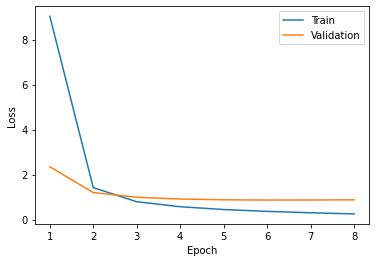

In [8]:
plot_loss(movies_cf_r_1_history);

In [9]:
y_movies_cf_r_1_test = movies_cf_r_1.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_r_1_train = movies_cf_r_1.predict([X_train['user_id'], X_train['movie_id']])

In [10]:
print('Test:')
print_rg_report(y_test, y_movies_cf_r_1_test)
print('Train:')
print_rg_report(y_train, y_movies_cf_r_1_train)

Test:
MSE = 0.8957783842523517
MAE = 0.6361070838388408
Train:
MSE = 0.4528036059720652
MAE = 0.4845547009631899


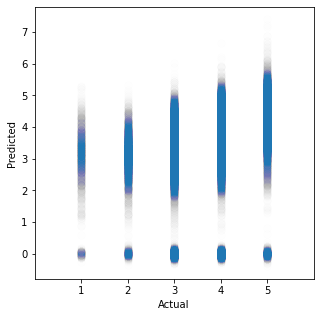

In [11]:
plot_preds(y_test, y_movies_cf_r_1_test);

## Variant 2

In [4]:
emb_size = 8

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    Flatten()
)
user_dot_movie = Dot(1, name='user_dot_movie')([user_emb, movie_emb])
movies_cf_r_2 = Model([user_input, movie_input], user_dot_movie, name='movies_cf_r_2')
movies_cf_r_2.summary()

Model: "movies_cf_r_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 8)         56984       user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 8)         263344      movie_id[0][0]                   
______________________________________________________________________________________

In [5]:
movies_cf_r_2.compile('adam', 'mse')
movies_cf_r_2_hist = movies_cf_r_2.fit(
    [X_train['user_id'], X_train['movie_id']], y_train, batch_size=128, epochs=8, validation_split=0.2,
    callbacks=[EarlyStopping(min_delta=0.1, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 17s 6ms/step - loss: 12.8448 - val_loss: 6.9063
Epoch 2/8
3011/3011 [==============================] - 15s 5ms/step - loss: 4.1247 - val_loss: 2.7374
Epoch 3/8
3011/3011 [==============================] - 15s 5ms/step - loss: 1.9607 - val_loss: 1.7152
Epoch 4/8
3011/3011 [==============================] - 15s 5ms/step - loss: 1.2878 - val_loss: 1.3322
Epoch 5/8
3011/3011 [==============================] - 15s 5ms/step - loss: 0.9878 - val_loss: 1.1500
Epoch 6/8
3011/3011 [==============================] - 15s 5ms/step - loss: 0.8202 - val_loss: 1.0473
Epoch 7/8
3011/3011 [==============================] - 15s 5ms/step - loss: 0.7122 - val_loss: 0.9845
Epoch 8/8
3011/3011 [==============================] - 14s 5ms/step - loss: 0.6366 - val_loss: 0.9399


In [6]:
movies_cf_r_2.save('data/movies_cf_r_2.h5')
save(movies_cf_r_2_hist.history, 'data/movies_cf_r_2_history.pickle')

### Evalueren

In [7]:
movies_cf_r_2 = load_model('data/movies_cf_r_2.h5')
movies_cf_r_2_history = load('data/movies_cf_r_2_history.pickle')

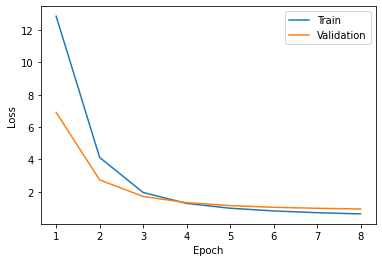

In [8]:
plot_loss(movies_cf_r_2_history);

In [9]:
y_movies_cf_r_2_test = movies_cf_r_2.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_r_2_train = movies_cf_r_2.predict([X_train['user_id'], X_train['movie_id']])

In [10]:
print('Test:')
print_rg_report(y_test, y_movies_cf_r_2_test)
print('Train:')
print_rg_report(y_train, y_movies_cf_r_2_train)

Test:
MSE = 0.9546954375906074
MAE = 0.6476780666497745
Train:
MSE = 0.6413337369670116
MAE = 0.5662579309811632


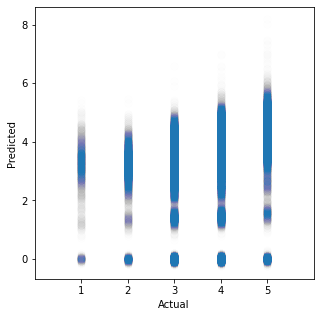

In [11]:
plot_preds(y_test, y_movies_cf_r_2_test);

# Classificatie

## Variant 1

In [12]:
emb_size = 64

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    Flatten()
)
user_movie = chain_layers(
    Concatenate()([user_emb, movie_emb]),
    Dense(n_classes, 'softmax')
)
movies_cf_c_1 = Model([user_input, movie_input], user_movie, name='movies_cf_c_1')
movies_cf_c_1.summary()

Model: "movies_cf_c_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 64)        455872      user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 64)        2106752     movie_id[0][0]                   
______________________________________________________________________________________

In [13]:
movies_cf_c_1.compile('adam', 'categorical_crossentropy', ['accuracy'])
movies_cf_c_1_hist = movies_cf_c_1.fit(
    [X_train['user_id'], X_train['movie_id']], Y_train, batch_size=128, epochs=8, validation_split=0.2,
    callbacks=[EarlyStopping('val_accuracy', min_delta=0.005, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 98s 32ms/step - loss: 0.9905 - accuracy: 0.5754 - val_loss: 0.9173 - val_accuracy: 0.5990
Epoch 2/8
3011/3011 [==============================] - 93s 31ms/step - loss: 0.8707 - accuracy: 0.6219 - val_loss: 0.9163 - val_accuracy: 0.6000
Epoch 3/8
3011/3011 [==============================] - 94s 31ms/step - loss: 0.8406 - accuracy: 0.6345 - val_loss: 0.9236 - val_accuracy: 0.5982
Epoch 4/8
3011/3011 [==============================] - 92s 31ms/step - loss: 0.8224 - accuracy: 0.6417 - val_loss: 0.9326 - val_accuracy: 0.5977


In [14]:
movies_cf_c_1.save('data/movies_cf_c_1.h5')
save(movies_cf_c_1_hist.history, 'data/movies_cf_c_1_history.pickle')

### Evalueren

In [15]:
movies_cf_c_1 = load_model('data/movies_cf_c_1.h5')
movies_cf_c_1_history = load('data/movies_cf_c_1_history.pickle')

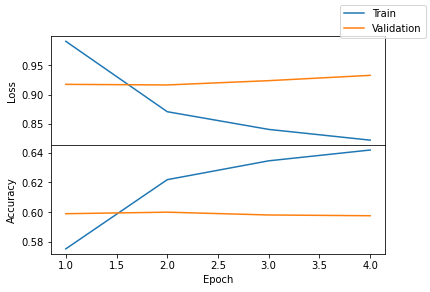

In [16]:
plot_acc(movies_cf_c_1_history);

In [17]:
Y_movies_cf_c_1_test = movies_cf_c_1.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_c_1_test = Y_movies_cf_c_1_test.argmax(axis=1)
Y_movies_cf_c_1_train = movies_cf_c_1.predict([X_train['user_id'], X_train['movie_id']])
y_movies_cf_c_1_train = Y_movies_cf_c_1_train.argmax(axis=1)

In [18]:
print('Test:')
print_cl_report(y_test - 1, y_movies_cf_c_1_test)
print('Train:')
print_cl_report(y_train - 1, y_movies_cf_c_1_train)

Test:
              precision    recall  f1-score   support

           0       0.29      0.07      0.11      1646
           1       0.33      0.04      0.08      4616
           2       0.57      0.46      0.51     42436
           3       0.60      0.77      0.68     77496
           4       0.64      0.47      0.54     34373

    accuracy                           0.60    160567
   macro avg       0.49      0.36      0.38    160567
weighted avg       0.59      0.60      0.58    160567

Train:
              precision    recall  f1-score   support

           0       0.50      0.11      0.18      4940
           1       0.48      0.07      0.12     13846
           2       0.62      0.50      0.55    127306
           3       0.63      0.80      0.70    232487
           4       0.67      0.51      0.58    103119

    accuracy                           0.63    481698
   macro avg       0.58      0.40      0.43    481698
weighted avg       0.63      0.63      0.61    481698



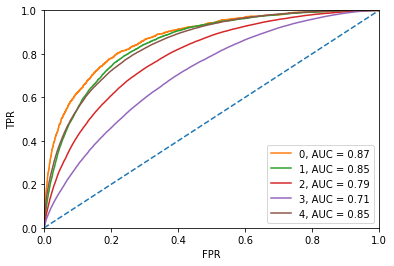

In [19]:
plot_rocc(y_test - 1, Y_movies_cf_c_1_test);

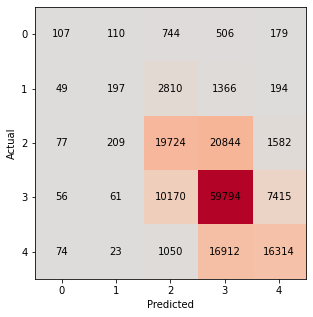

In [20]:
plot_confmat(y_test - 1, y_movies_cf_c_1_test);

In [21]:
print_rg_report(y_test - 1, y_movies_cf_c_1_test)

MSE = 0.5548960869917231
MAE = 0.44609415384232126


## Variant 2

In [12]:
emb_size = 8

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    Flatten()
)
user_movie = chain_layers(
    Concatenate()([user_emb, movie_emb]),
    Dense(n_classes, 'softmax')
)
movies_cf_c_2 = Model([user_input, movie_input], user_movie, name='movies_cf_c_2')
movies_cf_c_2.summary()

Model: "movies_cf_c_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 8)         56984       user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 8)         263344      movie_id[0][0]                   
______________________________________________________________________________________

In [13]:
movies_cf_c_2.compile('adam', 'categorical_crossentropy', ['accuracy'])
movies_cf_c_2_hist = movies_cf_c_2.fit(
    [X_train['user_id'], X_train['movie_id']], Y_train, batch_size=128, epochs=8, validation_split=0.2,
    callbacks=[EarlyStopping('val_accuracy', min_delta=0.005, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 24s 8ms/step - loss: 1.0361 - accuracy: 0.5640 - val_loss: 0.9212 - val_accuracy: 0.5985
Epoch 2/8
3011/3011 [==============================] - 24s 8ms/step - loss: 0.8790 - accuracy: 0.6200 - val_loss: 0.9116 - val_accuracy: 0.6033
Epoch 3/8
3011/3011 [==============================] - 24s 8ms/step - loss: 0.8504 - accuracy: 0.6328 - val_loss: 0.9137 - val_accuracy: 0.6018
Epoch 4/8
3011/3011 [==============================] - 23s 8ms/step - loss: 0.8327 - accuracy: 0.6395 - val_loss: 0.9203 - val_accuracy: 0.6015


In [14]:
movies_cf_c_2.save('data/movies_cf_c_2.h5')
save(movies_cf_c_2_hist.history, 'data/movies_cf_c_2_history.pickle')

### Evalueren

In [15]:
movies_cf_c_2 = load_model('data/movies_cf_c_2.h5')
movies_cf_c_2_history = load('data/movies_cf_c_2_history.pickle')

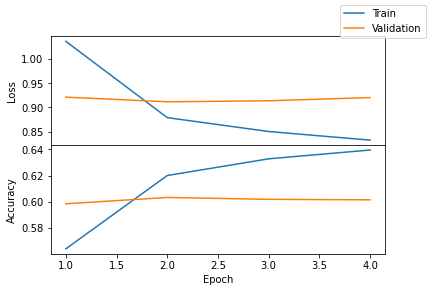

In [16]:
plot_acc(movies_cf_c_2_history);

In [17]:
Y_movies_cf_c_2_test = movies_cf_c_2.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_c_2_test = Y_movies_cf_c_2_test.argmax(axis=1)
Y_movies_cf_c_2_train = movies_cf_c_2.predict([X_train['user_id'], X_train['movie_id']])
y_movies_cf_c_2_train = Y_movies_cf_c_2_train.argmax(axis=1)

In [18]:
print('Test:')
print_cl_report(y_test - 1, y_movies_cf_c_2_test)
print('Train:')
print_cl_report(y_train - 1, y_movies_cf_c_2_train)

Test:
              precision    recall  f1-score   support

           0       0.37      0.02      0.03      1646
           1       0.37      0.01      0.03      4616
           2       0.57      0.48      0.52     42436
           3       0.60      0.76      0.67     77496
           4       0.62      0.49      0.55     34373

    accuracy                           0.60    160567
   macro avg       0.51      0.35      0.36    160567
weighted avg       0.59      0.60      0.58    160567

Train:
              precision    recall  f1-score   support

           0       0.56      0.03      0.05      4940
           1       0.45      0.02      0.03     13846
           2       0.60      0.51      0.55    127306
           3       0.62      0.78      0.70    232487
           4       0.66      0.52      0.58    103119

    accuracy                           0.62    481698
   macro avg       0.58      0.37      0.38    481698
weighted avg       0.62      0.62      0.61    481698



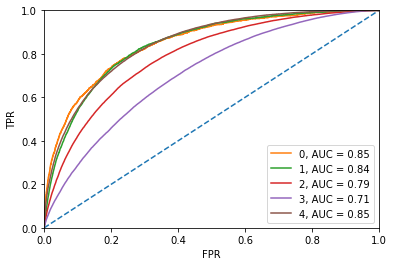

In [19]:
plot_rocc(y_test - 1, Y_movies_cf_c_2_test);

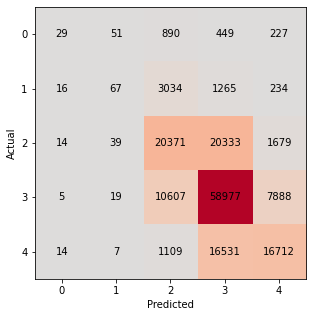

In [20]:
plot_confmat(y_test - 1, y_movies_cf_c_2_test);

In [21]:
print_rg_report(y_test - 1, y_movies_cf_c_2_test)

MSE = 0.5512589760037866
MAE = 0.4452969788312667
